<a href="https://colab.research.google.com/github/yamasaki-yu/test/blob/master/Experiment_for_L1L2Regulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L1,L2正規化の効果を可視化する<br>

参考url<br>
https://www.pynote.info/entry/matplotlib-contourf <br>
https://qiita.com/kazukiii/items/8f0e9559524c0bb0f5ba <br>
https://to-kei.net/neural-network/regularization/ <br>
https://www.sejuku.net/blog/78323 <br>
https://unisia-se.com/detail/48/ <br>
https://teratail.com/questions/221357 <br>


In [0]:
# ライブラリ関係のインポート
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import random
import functools 

## 認証を行ってgoogle driveをマウントする
from google.colab import drive
drive.mount('/content/drive')


In [0]:
# 損失関数のクラス
class LossFunction:
  
  # コンストラクタで損失関数・正規化の種類・正則化の強さλを指定
  def __init__(self, func ,reg="norm", lamb=0.01):
    self.func = func
    self.reg = reg
    self.lamb = lamb

  # 関数を実行するメソッド
  def function(self, w1, w2):
    
    # 正則化項を計算
    if self.reg is "norm" : regterm = 0
    elif self.reg is "l1" : regterm = self.lamb*( abs(w1) + abs(w2) )
    elif self.reg is "l2" : regterm = self.lamb*( w1**2 + w2**2  ) / 2
    else : regterm = 999999 #エラーの時

    # 関数 + 正則化項　を返す
    return self.func(w1,w2) + regterm


In [0]:
# 損失関数を定義
# ここでは2変数２次関数 y = 0.1(w1 - 0.9)^2 + 0.1(w2 - 0.4)^2 を定義

def quadratic(w1,w2):
    return 0.1*(w1-0.9)**2 + 0.1*(w2-0.4)**2

# 0を返す関数
def return_0(w1,w2):
    return 0


In [0]:
#関数 func を偏微分する関数
def perDiff(func, w1, w2):
  # Δw
  delta_w = 1e-4
  # 偏微分を定義に則って計算
  delta_y_w1 = ( func(w1+delta_w, w2) - func(w1-delta_w, w2) ) / (2*delta_w)
  delta_y_w2 = ( func(w1, w2+delta_w) - func(w1, w2-delta_w) ) / (2*delta_w)
  return delta_y_w1,delta_y_w2 

In [0]:
#最急降下法による最適化関数
def  gradient_descent(func, rate, n_iter, print_seq = False ):

  # 初期値は -20~ +20の乱数で生成
  w1 = random.random() * 40 -20 
  w2 = random.random() * 40 -20

  for i  in range(1,n_iter+1):
    # 偏微分の計算
    grad_w1, grad_w2 = perDiff(func, w1, w2)
    # パラメータ更新
    w1 -= grad_w1 * rate
    w2 -= grad_w2 * rate
    # 画面出力
    if ( i % 20  == 0 and print_seq == True ) or i == n_iter:
      print("{}/{}  w1={:.4f},  w2={:.4f},   y={:.4f}" .format(i,n_iter, w1, w2, func(w1,w2) ))

  return w1,w2


In [0]:
# 高等線の描画関数
# mode 0:両方　1:fillのみ　2:lineのみ
def draw_contour(func_fill, func_line, mode="0", title="default_title", opt_sol=(0,0)):

  #画像の保存の準備
  fig = plt.figure()


  # 範囲
  plt.xlim([-0.3,1.2])
  plt.ylim([-0.3,1.0])
  #plt.xlim([-2,2])
  #plt.ylim([-2,2])

  # アスペクト比を揃える
  plt.gca().set_aspect('equal') 


  # グリッドの作成
  x = np.arange(-0.3, 1.3, 0.01) # x軸
  y = np.arange(-0.3, 1.1, 0.01) # y軸
  #x = np.arange(-2, 2, 0.05) # x軸
  #y = np.arange(-2, 2, 0.05) # y軸
  X, Y = np.meshgrid(x, y)

  # グリッドでの値を取得
  if mode is "0" or mode is "1" : Z_fill = func_fill(X,Y) *(-1)
  if mode is "0" or mode is "2" : Z_line = func_line(X,Y) 

  # 高等線の描画
  if mode is "0" or mode is "1" : cont = plt.contourf(X, Y, Z_fill ,cmap='ocean',levels=50, alpha=0.6)
  if mode is "0" or mode is "2" : 
    cont = plt.contour(X, Y, Z_line ,cmap='spring')
    cont.clabel(fmt='%1.3f', fontsize=10)

  # 最適解の描画
  if opt_sol!=(0,0) :  
    plt.scatter(opt_sol[0],opt_sol[1],color="black")
    plt.annotate("{} \n  ({:.2f},{:.2f})" .format(title + " opt w", opt_sol[0],opt_sol[1]), xy=(opt_sol[0],opt_sol[1]))

  # タイトル
  plt.title(title)

  # グリッド
  plt.grid(which='major',color='black',linestyle='-')

  # ラベル
  plt.xlabel('w1')
  plt.ylabel('w2')

  # 描画
  plt.show()

  # グラフをファイルに保存する
  fig.savefig('/content/drive/My Drive/' + title + ".jpg")

In [13]:
# 正則化の種類ごとに関数の最適化を行う

# 正則化なし
# 損失関数のインスタンスを作成
lf_norm = LossFunction(quadratic, "norm" ,0.01)
# 最急降下法を実行
opt_w_norm = gradient_descent(lf_norm.function,  0.05, 2000, False)

# L1正則化
# 損失関数のインスタンスを作成
lf_l1 = LossFunction(quadratic, "l1" ,0.07)
# 最急降下法を実行
opt_w_l1 = gradient_descent(lf_l1.function,  0.05, 2000, False)

#L2正則化
# 損失関数のインスタンスを作成
lf_l2 = LossFunction(quadratic, "l2" ,0.1)
# 最急降下法を実行
opt_w_l2 = gradient_descent(lf_l2.function,  0.05, 2000, False)

2000/2000  w1=0.9000,  w2=0.4000,   y=0.0000
2000/2000  w1=0.5500,  w2=0.0500,   y=0.0665
2000/2000  w1=0.6000,  w2=0.2667,   y=0.0323


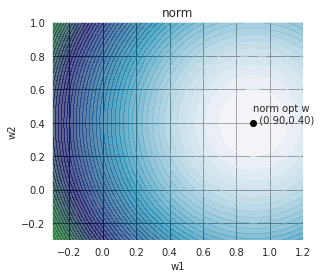

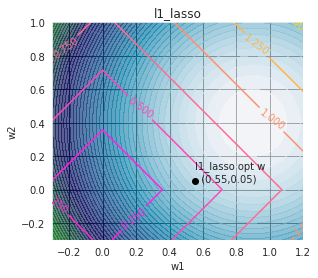

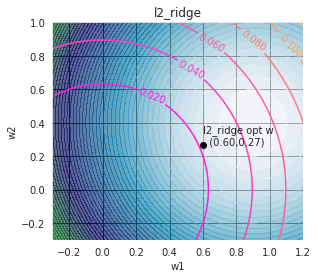

In [24]:
# 描画用の関数
org_lossfunc = LossFunction(quadratic, "norm" ,0.01)
regterm_l1 = LossFunction(return_0, "l1" ,0.7)
regterm_l2 = LossFunction(return_0, "l2" ,0.1)

draw_contour(org_lossfunc.function, return_0, mode="1", title="norm", opt_sol=opt_w_norm)
draw_contour(org_lossfunc.function, regterm_l1.function, mode="0", title="l1_lasso", opt_sol=opt_w_l1)
draw_contour(org_lossfunc.function, regterm_l2.function, mode="0", title="l2_ridge", opt_sol=opt_w_l2)

#draw_contour(org_lossfunc.function, regterm_l1.function, mode="2", title="l1_lasso")
#draw_contour(org_lossfunc.function, regterm_l2.function, mode="2", title="l2_ridge")


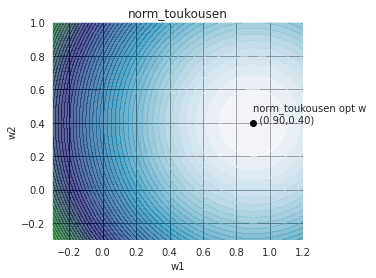

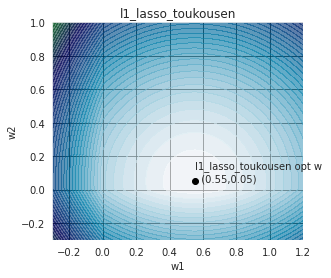

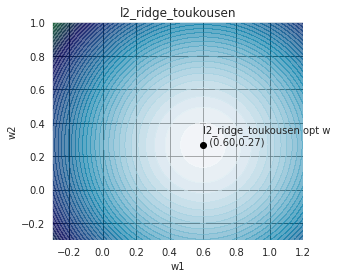

In [26]:
# 損失関数の高等線をみてみる
draw_contour(lf_norm.function, regterm_l1.function, mode="1", title="norm_toukousen", opt_sol=opt_w_norm)
draw_contour(lf_l1.function, regterm_l1.function, mode="1", title="l1_lasso_toukousen", opt_sol=opt_w_l1)
draw_contour(lf_l2.function, regterm_l2.function, mode="1", title="l2_ridge_toukousen", opt_sol=opt_w_l2)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08198001633340518, tolerance: 0.0002610393663394442
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/

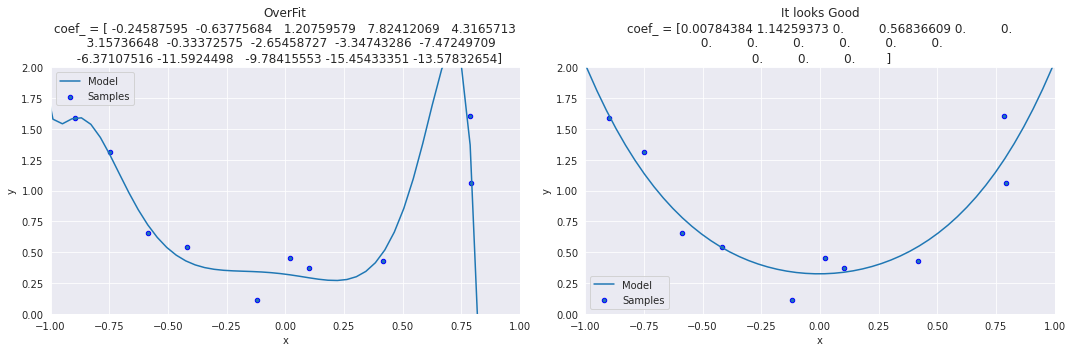

In [0]:
# 過学習がおきている場合 vs おきていない場合　の関数の描画

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from sklearn.linear_model import ElasticNet


def rand_func(x, error=1, random_state=0):
    np.random.seed(random_state)
    return np.random.normal(2*x**2, error)

error = 0.2
n_samples = 10
np.random.seed(3)
X = np.random.random(n_samples)*2 - 1.0
y = rand_func(X, error)

alphas = [0, 0.01]
deg = 15

fig = plt.figure(figsize=(15, 5))

for i in range(len(alphas)):

  if alphas[i] == 0 : title1 =  "OverFit"
  else  : title1 =  "It looks Good"

  polynomial_features = PolynomialFeatures(degree=deg, include_bias=False)
  e_net = ElasticNet(alpha = alphas[i], l1_ratio = 0.5)
  pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("e_net", e_net)])
    
  pipeline.fit(X.reshape(-1, 1), y)

  scores = cross_val_score(pipeline, X.reshape(-1, 1), y,
                             scoring="neg_mean_squared_error", cv=5)

  X_test = np.linspace(-2, 2, 100)



  ax = plt.subplot(1, 2, i + 1)
  ax.plot(X_test, pipeline.predict(X_test.reshape(-1, 1)), label="Model")
  ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.xlim((-1, 1))
  plt.ylim((0, 2))
  plt.legend(loc="best")
  plt.title("{}\ncoef_ = {}".format(
        title1, pipeline.named_steps["e_net"].coef_))
  plt.tight_layout()

plt.show()

# グラフをファイルに保存する
#fig.savefig('/content/drive/My Drive/overfit.png')

